In [ ]:
import numpy as np
import scipy.optimize
from gymnasium.wrappers import TimeLimit

from src.environments import ea
from src.eval import Study
from src.eval.eval_rl_v3_sim import generate_trials
from src.trial import Trial
from src.wrappers import RecordEpisode

In [ ]:
def evaluate_optimizer(
    config: dict,
    write_data: bool = True,
    seed: int | None = None,
    evaluation_name: str = "unnamed",
) -> None:
    trials = generate_trials(num=20, seed=seed)

    for i, trial in enumerate(trials):
        evaluate_on_trial(i, trial, config, write_data, evaluation_name)


def evaluate_on_trial(
    trial_index: int,
    trial: Trial,
    config: dict,
    write_data: bool = True,
    evaluation_name: str = "unnamed",
) -> None:
    # Create the environment
    env = ea.TransverseTuning(
        backend="cheetah",
        backend_args={
            "incoming_mode": trial.incoming_beam,
            "max_misalignment": 5e-4,
            "misalignment_mode": trial.misalignments,
            "simulate_finite_screen": False,
        },
        action_mode="direct",
        magnet_init_mode=config["magnet_init_mode"],
        max_quad_setting=config["max_quad_setting"],
        target_beam_mode=np.zeros(4),
        target_threshold=None,
        threshold_hold=5,
        clip_magnets=True,
    )
    env = TimeLimit(env, 150)
    if write_data:
        env = RecordEpisode(
            env,
            save_dir=(f"data/{evaluation_name}/problem_{trial_index:03d}"),
        )

    # Actual optimisation
    observation, info = env.reset()
    x0 = observation["magnets"]

    def objective_function(x):
        observation, _, _, _, _ = env.step(x)
        mae = np.mean(np.abs(observation["beam"] - observation["target"]))
        return mae

    res = scipy.optimize.minimize(
        objective_function,
        x0,
        method="nelder-mead",
        options={
            "xatol": 1e-8,
            "disp": True,
            "maxfev": env.get_wrapper_attr(
                "_max_episode_steps"
            ),  # Maximum number of function evaluations
        },
    )

    env.close()

In [3]:
evaluation_name = "nelder_mead"

evaluate_optimizer(
    config={"magnet_init_mode": "random", "max_quad_setting": 30},
    write_data=True,
    seed=42,
    evaluation_name=evaluation_name,
)

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_59362/1921031731.py:56: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(


In [5]:
study = Study.load(f"data/{evaluation_name}")

In [6]:
print(f"Final MAE: {study.median_final_mae() * 1e6:.0f} μm")
print(f"Steps to convergence: {study.median_steps_to_convergence(threshold=4e-5)}")
print(f"Sum of magnet changes: {study.median_sum_of_normalized_magnet_changes():.2f}")

Final MAE: 281 μm
Steps to convergence: 115.5
Sum of magnet changes: 12.71


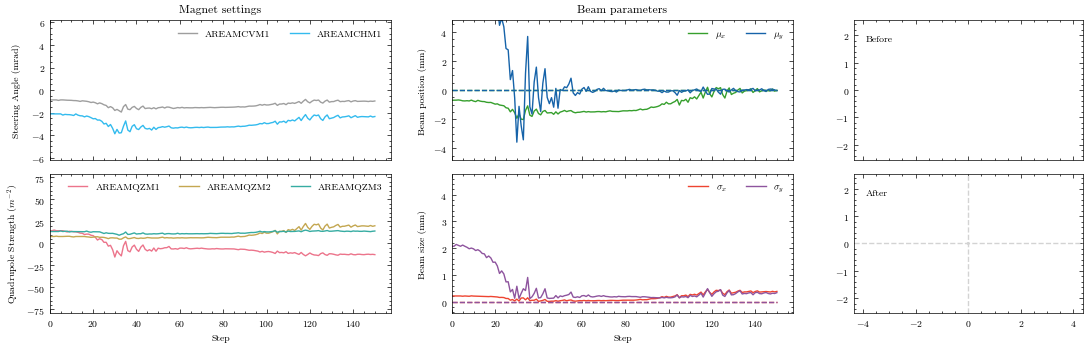

In [7]:
_ = study.episodes[2].plot_summary()